# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [29]:
# import libraries
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sys

import re
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, balanced_accuracy_score, fbeta_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from time import time
import pickle

In [4]:
# setting for runtime needed:
n_draws=200 # set None to run the notebook on the unlimited dataset (runs hours!)

In [5]:
# load data from database
# read from correct directory <- inspired by: https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-directory

def load_data(n_draws=None):
    '''
    Load data from a DB, specifically from a disaster.db the table 'disaster_table'.
    
    Input: 
    n_draws (optional): sample draws from full file; can be used to get the code up and
                        running with a reduced workload for estimation
    Output:
    X: a Pandas series as model independent variable
    Y: a Pandas dataframe as model dependent variables
    '''
    engine = create_engine('sqlite:///' + os.path.join(os.getcwd(), os.pardir, 'data') 
                           + '/DisasterResponse.db')
    
    # for run on AWS Sagemaker:
    #engine = create_engine('sqlite:///disaster.db')

    df = pd.read_sql_table('disaster_table', con=engine)

    # using the message column to predict 36 categories
    col_names = ['related', 'request', 'offer',
           'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
           'security', 'military', 'child_alone', 'water', 'food', 'shelter',
           'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
           'infrastructure_related', 'transport', 'buildings', 'electricity',
           'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
           'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
           'other_weather', 'direct_report']
    X = df.message
    y = df[col_names]
    
    if n_draws:
        X = X.sample(n=n_draws) # default is no replacement
        y = y.loc[X.index] # same lines
    return X, y#, df

X, y = load_data()

In [7]:
engine = create_engine('sqlite:///' + os.path.join(os.getcwd(), os.pardir, 'data') 
                           + '/DisasterResponse.db')
df = pd.read_sql_table('disaster_table', con=engine)
categories = df.iloc[:,4:40].sum().sort_values(ascending=False)
categories.index

Index(['related', 'aid_related', 'weather_related', 'direct_report', 'request',
       'other_aid', 'food', 'earthquake', 'storm', 'shelter', 'floods',
       'medical_help', 'infrastructure_related', 'water', 'other_weather',
       'buildings', 'medical_products', 'transport', 'death',
       'other_infrastructure', 'refugees', 'military', 'search_and_rescue',
       'money', 'electricity', 'cold', 'security', 'clothing', 'aid_centers',
       'missing_people', 'hospitals', 'fire', 'tools', 'shops', 'offer',
       'child_alone'],
      dtype='object')

In [8]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [9]:
X.shape, y.shape

((25993,), (25993, 36))

In [10]:
X

0        Weather update - a cold front from Cuba that c...
1                  Is the Hurricane over or is it not over
2                          Looking for someone but no name
3        UN reports Leogane 80-90 destroyed. Only Hospi...
4        says: west side of Haiti, rest of the country ...
                               ...                        
25988    The training demonstrated how to enhance micro...
25989    A suitable candidate has been selected and OCH...
25990    Proshika, operating in Cox's Bazar municipalit...
25991    Some 2,000 women protesting against the conduc...
25992    A radical shift in thinking came about as a re...
Name: message, Length: 25993, dtype: object

In [12]:
X[7]

'Please, we need tents and water. We are in Silo, Thank you!'

### 2. Write a tokenization function to process your text data

In [13]:
def tokenize(text, stop_words_remove=True):
    '''
    Tokenize text messsages and cleaning for Machine Learning use.
    
    Input: str
    Output: list
    '''
    text = re.sub(r'[^A-Za-z0-9]', ' ', text.lower())
    words = word_tokenize(text)
    if stop_words_remove:
        result = [WordNetLemmatizer().lemmatize(w) for w in words 
                  if w not in stopwords.words('english')]
    if stop_words_remove==False:
        result = [WordNetLemmatizer().lemmatize(w) for w in words]    
    return result

In [14]:
tokenize(X[7])

['please', 'need', 'tent', 'water', 'silo', 'thank']

In [15]:
# optional: look at part of vectorized matrix 
#vectorizer = TfidfVectorizer(tokenizer=tokenize)
#transformed = vectorizer.fit_transform(X[0:4])
#transformed.toarray()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [16]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10))) #  KNeighborsClassifier
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
pipeline = pipeline.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [19]:
# predict
y_pred = pipeline.predict(X_test)

In [20]:
# data frame with column names
y_pred_df = pd.DataFrame(y_pred)
col_names = ['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']
y_pred_df.columns = col_names
y_pred_df.head(2)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Accuracy problematic for unbalanced data
We have a quite imbalanced dataset (small amount of positives per category) hence the accuracy -- defined as (correctly labeled items) / (all items) -- is a misleading metric. Example: when 1% only is positive the accuracy can be 99% when no positive value is predicted correctly.

In [21]:
y_test['money'].hist()

In [22]:
print(classification_report(y_test['request'], y_pred_df['request']))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5382
           1       0.79      0.41      0.54      1117

    accuracy                           0.88      6499
   macro avg       0.84      0.69      0.73      6499
weighted avg       0.87      0.88      0.86      6499



#### some theory from Udacity intro to machine learning class:

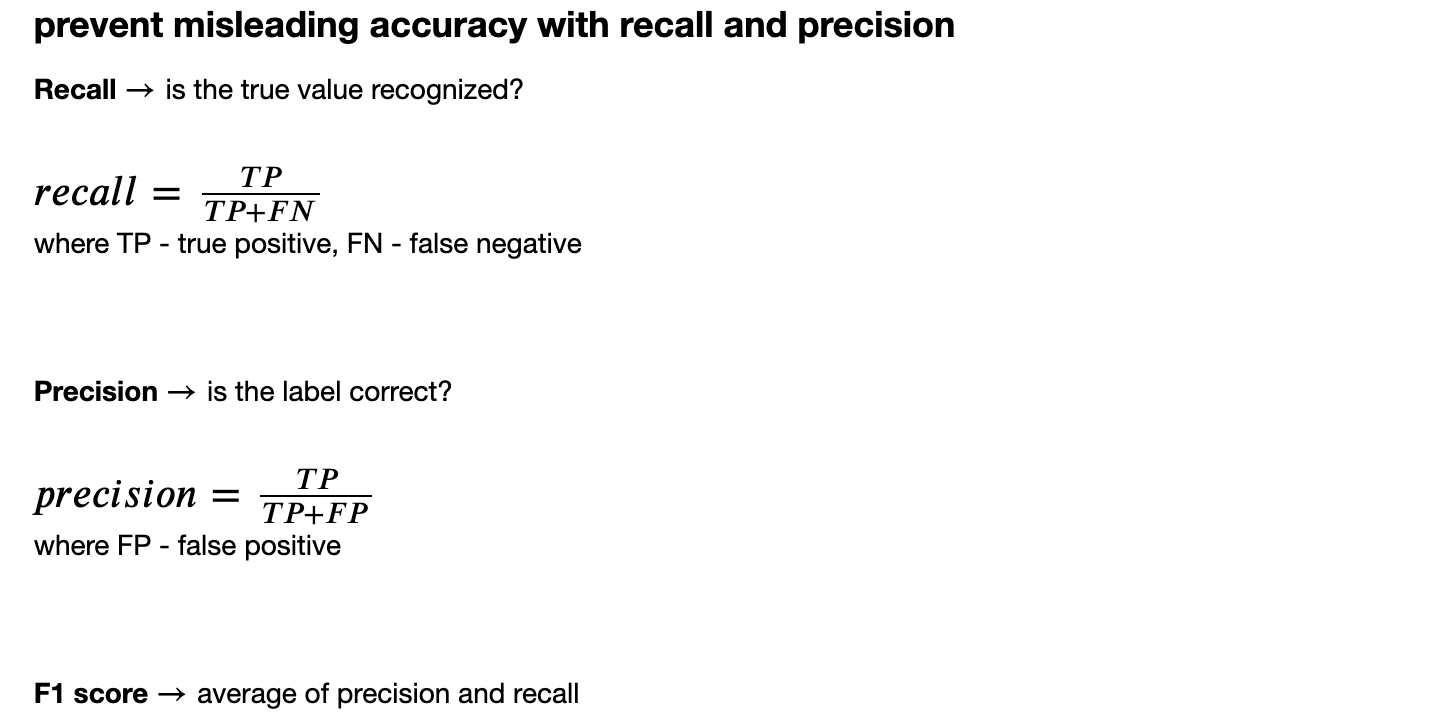

### Report the f1 score, precision and recall for each output category of the dataset

In [23]:
# this cell was used to develop display_results(y_test, y_pred)
# nothing printed here

report = {}
for col in y_pred_df.columns:
    output = classification_report(y_test[col], y_pred_df[col], output_dict=True)
    report[col] = {} # inspired by https://stackoverflow.com/questions/16333296/how-do-you-create-nested-dict-in-python
    for i in output:   
        if i == 'accuracy':
            break
        report[col]['f1_' + i] = output[i]['f1-score']
        report[col]['precision_' + i] = output[i]['precision']
        report[col]['recall_' + i] = output[i]['recall']

report_df = pd.DataFrame(report).transpose()
report_df = report_df[report_df.columns.sort_values()]

res_before_gridsearch = report_df.mean()

/opt/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### the above into a evalutation function:

In [24]:
def display_results(y_test, y_pred):
    """
    Provide model results in a table separated for column classes.
    
    Input: 
    - y_test: labels from test dataset
    - y_pred: predicted labels as model outcome
    
    Output:
    - [0]: dataframe with evaluation eparated for column classes
    - [1]: dataframe with mean column values of [0]
    """
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df.columns = col_names
    report = {}
    for col in y_pred_df.columns:
        output = classification_report(y_test[col], y_pred_df[col], output_dict=True)
        report[col] = {} # inspired by https://stackoverflow.com/questions/16333296/how-do-you-create-nested-dict-in-python
        for i in output:   
            if i == 'accuracy':
                break
            report[col]['f1_' + i] = output[i]['f1-score']
            report[col]['precision_' + i] = output[i]['precision']
            report[col]['recall_' + i] = output[i]['recall']
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df[report_df.columns.sort_values()]
    report_df_mean = report_df.mean()
    return report_df, report_df_mean

In [25]:
# cross-check: not weighted f1 score
np.nanmean(np.concatenate((display_results(y_test, y_pred)[0].f1_0.values, 
                           display_results(y_test, y_pred)[0].f1_1.values)))

0.6069508838127323

In [26]:
# check function output [0]
display_results(y_test, y_pred)[0]

,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1
related,0.540356,0.882904,0.623797,0.853809,0.476604,0.914052
request,0.930619,0.538280,0.888476,0.786575,0.976960,0.409132
offer,0.997764,0.000000,0.995538,0.000000,1.000000,0.000000
aid_related,0.794824,0.659021,0.745320,0.740792,0.851373,0.593508
medical_help,0.959852,0.161616,0.926249,0.666667,0.995985,0.091954
medical_products,0.977447,0.210526,0.959155,0.633333,0.996450,0.126246
search_and_rescue,0.987916,0.093567,0.976572,0.727273,0.999527,0.050000
security,0.990837,0.016667,0.982143,0.333333,0.999687,0.008547
military,0.984953,0.193277,0.972003,0.676471,0.998253,0.112745
child_alone,1.000000,NaN,1.000000,NaN,1.000000,NaN


In [30]:
# check function output [1]
display_results(y_test, y_pred)[1]

f1_0           0.957790
f1_1           0.246088
precision_0    0.941237
precision_1    0.581826
recall_0       0.976300
recall_1       0.186947
dtype: float64

### 6. Improve your model
Use grid search to find better parameters. 

In [31]:
# suppress warnings for the user # https://docs.python.org/3/library/warnings.html
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### 6a) first: steps 1-5 more concise

scoring / what to optimize:<br>using the __f1-score__ with average='weighted' to account for inbalanced 'true instances for each label' (source [scikit f1-score doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and [scikit model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring))

In [32]:
def build_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10))) #  KNeighborsClassifier
    ])
    return pipeline

def train_model(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = model.fit(X_train, y_train)
    
    # model test results
    y_pred = model.predict(X_test)
    print(display_results(y_test, y_pred)[1])
    
    # scoring: evaluate f1-score on test data
    print('\n f1 weighted:', round(f1_score(y_test, y_pred, average='weighted'), 2)) 
    return model # to export fitted model

start = time()
X, y = load_data(n_draws=n_draws) # for getting results fast
model = build_model()
model = train_model(X, y, model) # the fitted model
print('\n Runtime was %.1f seconds.'% (time() - start))

f1_0           0.932718
f1_1           0.043077
precision_0    0.903089
precision_1    0.055004
recall_0       0.969322
recall_1       0.042545
dtype: float64

 f1 weighted: 0.25

 Runtime was 2.1 seconds.


### 6b) second: enhance model
### 6b 1) using GridSearchCV

### approach to imbalanced data  
- promising, but does not work for our multi-column dependent:<br>balanced accuracy: "avoids inflated performance estimates on imbalanced datasets (...) for balanced datasets, the score is equal to accuracy" [scikit source](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) and [scikit metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- use Fbeta which is the F1-score introduced above for Beta=1 ([source](https://machinelearningmastery.com/fbeta-measure-for-machine-learning/)).

#### GridSearchCV (limited to one estimator)
__note__: the cell below runs 7 hours (!!) on the local machine used when applied to the full dataset based on 6 candidates and 3-fold cross-validation $\rightarrow$ use a sample from the full data with `load_data(n_draws=200)` 

gives the full run gives the result:
```
f1_0           0.959594
f1_1           0.262201
precision_0    0.949058
precision_1    0.599270
recall_0       0.973764
recall_1       0.212757
dtype: float64

 f1 weighted: 0.58

 Runtime was 25390.4 seconds.
Best parameters: {'clf__estimator__n_estimators': 200, 'tfidf__sublinear_tf': True}```


In [33]:
def build_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier())) #  KNeighborsClassifier
    ])

    parameters = { 
        'tfidf__sublinear_tf': [True, False],
        'clf__estimator__n_estimators': [7, 10, 200]
    }
    
    # average = 'weighted' -> "Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.""
    # option 'zero_division=0' fails with fbeta for some reason(?): true positive + false positive == 0 or true positive + false negative == 0 -> set 0 
   
    # source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
    fbeta = make_scorer(fbeta_score, beta=2, average='weighted') # more weight on recall
    #f1_scorer = make_scorer(f1_score, average='weighted', zero_division=0)
    cv = GridSearchCV(pipeline, param_grid=parameters, iid=False, cv=3, scoring=fbeta)
    return cv

start = time()
X, y = load_data(n_draws=n_draws) # n_draws=200 for getting results fast
model = build_model()
model = train_model(X, y, model) # the fitted model
print('\n Runtime was %.1f seconds.'% (time() - start))
print('Best parameters:', model.best_params_)

f1_0           0.947833
f1_1           0.132386
precision_0    0.951944
precision_1    0.247200
recall_0       0.968237
recall_1       0.109851
dtype: float64

 f1 weighted: 0.38

 Runtime was 69.9 seconds.
Best parameters: {'clf__estimator__n_estimators': 7, 'tfidf__sublinear_tf': False}


```
f1_0           0.934462
f1_1           0.099801
precision_0    0.906125
precision_1    0.147313
recall_0       0.967786
recall_1       0.088319
dtype: float64

 f1 weighted: 0.35

 Runtime was 55.2 seconds.
 ```

In [34]:
# on the initial train-test-split: check the model performance
y_pred = model.predict(X_test)
print('fbeta 1-score overall:', fbeta_score(y_test, y_pred, beta=1, average='weighted')) # is F1-score
print('fbeta 2-score overall:', fbeta_score(y_test, y_pred, beta=2, average='weighted')) # is F2-score

fbeta 1-score overall: 0.34655719519278094
fbeta 2-score overall: 0.3310494642086524


### 6b 2) using RandomizedSearchCV

parameter for _randomized_ search can be __a range__

randomized search randomly picks for each iteration (n_iter) a parameter from the parameter space

In [35]:
# inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-download-auto-examples-model-selection-plot-randomized-search-py

def build_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier())) #  KNeighborsClassifier
    ])

    parameters = { 
        'tfidf__sublinear_tf': [True, False],
        'clf__estimator__n_estimators': np.arange(7,200+1), # instead of specific values: [7, 10, 100, 200]
    }
    
    fbeta = make_scorer(fbeta_score, beta=2, average='weighted')
    #f1_scorer = make_scorer(f1_score, average='weighted')
    random = RandomizedSearchCV(pipeline, param_distributions=parameters, iid=False, cv=3,
                     scoring=fbeta, n_iter=5) 
    return random

start = time()
X, y = load_data(n_draws=n_draws) # n_draws=200 for getting results fast
model = build_model()
model = train_model(X, y, model) # the fitted model
print('\n Runtime was %.1f seconds.'% (time() - start))
print('Best parameters:', model.best_params_)

f1_0           0.930390
f1_1           0.097414
precision_0    0.904833
precision_1    0.195565
recall_0       0.971392
recall_1       0.077016
dtype: float64

 f1 weighted: 0.3

 Runtime was 64.5 seconds.
Best parameters: {'tfidf__sublinear_tf': False, 'clf__estimator__n_estimators': 15}


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [36]:
y_pred = model.predict(X_test)
results = display_results(y_test, y_pred)

In [37]:
results[0]

,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1
related,0.106538,0.869910,0.564103,0.778023,0.058824,0.986408
request,0.912943,0.241972,0.847857,0.729730,0.988852,0.145031
offer,0.997764,0.000000,0.995538,0.000000,1.000000,0.000000
aid_related,0.756253,0.354295,0.631728,0.741481,0.941922,0.232755
medical_help,0.958377,0.018904,0.920364,0.714286,0.999665,0.009579
medical_products,0.976444,0.019672,0.954119,0.750000,0.999839,0.009967
search_and_rescue,0.987537,0.000000,0.975381,0.000000,1.000000,0.000000
security,0.990994,0.016949,0.982148,1.000000,1.000000,0.008547
military,0.984055,0.000000,0.968611,0.000000,1.000000,0.000000
child_alone,1.000000,NaN,1.000000,NaN,1.000000,NaN


In [38]:
results[1]

f1_0           0.939884
f1_1           0.076231
precision_0    0.924699
precision_1    0.621013
recall_0       0.971128
recall_1       0.058595
dtype: float64

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [39]:
# based on code from: https://github.com/davidsbatista/machine-learning-notebooks/blob/master/hyperparameter-across-models.ipynb
# my enhancements: 
# add support for pipelines, RandomizedSearchCV, 
# output best overall model, assert statements, description


# imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

class HyperclassifierTuning:
    """Train multiple classifiers/pipelines with GridSearchCV or RandomizedSearchCV.
    
    HyperclassifierTuning implements a "train_model" and "evaluate_model" method.
    
    "train_model" returns the optimal model according to the scoring metric.
    
    "evaluate_model" gives the results for all classifiers/pipelines.
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.grid_results = {}
    
    def train_model(self, X_train, y_train, search='grid', **search_kwargs):
        """
        Optimizing over multiple classifiers or pipelines.
        
        Input: 
        X : array or dataframe with features; this should be a training dataset
        y : array or dataframe with label(s); this should be a training dataset

        Output: 
        returns the optimal model according to the scoring metric
        
        Parameters:
        search : str, default='grid'
            define the search
            ``grid`` performs GridSearchCV 
            ``random`` performs RandomizedSearchCV
            
        **search_kwargs : kwargs
            additional parameters passed to the search
        """
        grid_results = {}
        best_score = 0
        
        for key in self.models.keys():
            print('GridSearchCV for {}'.format(key), '...')
            assert search in ('grid', 'random'), 'search parameter out of range'
            if search=='grid':
                grid = GridSearchCV(self.models[key], self.params[key], **search_kwargs)
            if search=='random':
                grid = RandomizedSearchCV(self.models[key], self.params[key], **search_kwargs)
            grid.fit(X_train, y_train)
            self.grid_results[key] = grid
        
            if grid.best_score_ > best_score: # to return best model
                best_score = grid.best_score_
                best_model = grid
                
        print('Search is done.')
        return best_model # allows to predict with the best model overall
        
    def evaluate_model(self, sort_by='mean_test_score', show_timing_info=False):
        """
        Provides sorted model results for multiple classifier or pipeline runs of
        GridSearchCV or RandomizedSearchCV.
        
        Input: Fitted search object (accesses cv_results_).  
        Output: Dataframe with a line for each training run including estimator name, parameters, etc.
        Parameters:
        sort_by: the metric to rank the model results
        """
        results = []
        for key, result in self.grid_results.items():
            print('results round for:', key) 
            # get rid of column specific to estimator to use df for multiple estimators 
            # regex 'not in': https://stackoverflow.com/questions/1971738/regex-for-all-strings-not-containing-a-string#1971762
            result = pd.DataFrame(result.cv_results_).filter(regex='^(?!.*param_).*')
            if show_timing_info==False: # skip timing info
                result = result.filter(regex='^(?!.*time).*')
            # add column with the name of the estimator
            result = pd.concat((pd.DataFrame({'Estimator': [key] * result.shape[0] }), result), axis=1)
            results.append(result)
                
        # handle combined classifier results: 
        # sort by target metric and remove subset rank scores
        df_results = pd.concat(results).sort_values([sort_by], ascending=False).\
                        reset_index().drop(columns = ['index', 'rank_test_score'])
        return df_results

The main search for the best model. Last run was interrupted due to long runtime in the Jupyter notebook, however in commandline this code is used to provide the best estimate.

In [40]:
def build_model():
    models = {
        'AdaBoost': Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
            ('clf', MultiOutputClassifier(AdaBoostClassifier()))  
        ]), 
        'RandomForest': Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
            ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ]),    
        #'LinearSVC': Pipeline([
        #    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        #    ('clf', MultiOutputClassifier(LinearSVC(max_iter=100, class_weight='balanced')))  
        #])
        #'GradientBoosting': Pipeline([
        #    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        #    ('clf', MultiOutputClassifier(GradientBoostingClassifier()))  
        #]),  
        #'LogisticRegression': Pipeline([
        #    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        #    ('clf', MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)))  
        #])
    }
    params = { 
        'AdaBoost': { 'clf__estimator__n_estimators': np.arange(16,32+1) },
        'RandomForest': { 'clf__estimator__n_estimators': np.arange(7,200+1) },
        #'LinearSVC': { 'clf__estimator__C': np.linspace(0.1, 100, num=1000) }
        #'GradientBoosting' : { 'clf__estimator__learning_rate': [0.8, 1.0] },
        #'LogisticRegression': { 'clf__estimator__C': [0.1, 1] }
    }
    #scorer = make_scorer(balanced_accuracy_score)
    scorer = make_scorer(fbeta_score, beta=2, average='weighted')
    return models, params, scorer

models, params, scorer = build_model()
search = HyperclassifierTuning(models, params)
# train-test-split performed above
# cv and n_iter is set too low for useful results -> allow reasonable runtimes on an average local machine
# set cv = 10 for useful results
best_model = search.train_model(X_train, y_train, search='random', scoring=scorer, n_iter=2, cv=2, iid=False)
search.evaluate_model()

GridSearchCV for AdaBoost ...
GridSearchCV for RandomForest ...


KeyboardInterrupt: 

### 9. Export your model as a pickle file

In [ ]:
# see https://scikit-learn.org/stable/modules/model_persistence.html
# hints: dump and load in same software versions 

def save_model(model, model_filepath):
    with open(model_filepath, 'wb') as file:
        pickle.dump(model, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

## Extension: Data for the app: scatter plot for word count per message

In [41]:
# message lengths in words including stop words
message_words_stopwords = X[0:100].apply(lambda x: tokenize(x, stop_words_remove=False)).apply(len).value_counts()
# message lengths in words without stop words
message_words_no_stopwords = X[0:100].apply(tokenize).apply(len).value_counts()

messages = pd.DataFrame(message_words_stopwords).reset_index()
messages['type'] = 'including stopwords' 

messages2 = pd.DataFrame(message_words_no_stopwords).reset_index()
messages2['type'] = 'without stopwords' 

message_scatter_data = pd.concat([messages, messages2])
message_scatter_data.head()

,index,message,type
0,17,7,including stopwords
1,21,6,including stopwords
2,8,5,including stopwords
3,9,5,including stopwords
4,6,4,including stopwords
